# Reducing uncertainty through measurement to improve design

Intro text ...

#### Setup

In [1]:
import os
from tqdm.auto import tqdm
import numpy as np
from numpy import random
from scipy import stats
from scipy.stats import linregress

from models import sample_posterior
from models import run_model
from functools import partial
from utils import get_Gurobi_WLS_env, fmt_design_results

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colormaps as cmaps

from cmdstanpy import CmdStanModel

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.WARNING)

In [2]:
env = get_Gurobi_WLS_env(silence=True)
run_model = partial(run_model, env=env)
random.seed(42)

In [3]:
solar_years = range(2012,2018)
load_years = range(2012,2018)

# hyperparameters of probabilistic models
load_mean = 100
load_std = 10
msr_error = 0.025

#### Sample from prior distribution of load and measurements

In [4]:
nsamples = 1000

thetas = stats.truncnorm.rvs(-2, 2, loc=load_mean, scale=load_std, size=nsamples)
zs = stats.norm.rvs(loc=thetas, scale=thetas*msr_error)

In [5]:
print(thetas[:10])
print(zs[:10])

[ 96.95171998 114.77332139 105.87119149 102.38283774  90.52413038
  90.52322622  85.82654194 110.34355647 102.44334849 105.20393185]
[ 97.38243042 110.94177371 106.87749148 103.94567527  91.79099397
  92.96912017  87.6158583  111.61024555 102.26364822 100.83544133]


#### Sample from posterior load distribution

In [6]:
z = zs[1]
print(z)

110.94177370884726


In [7]:
# load Stan model
stan_model = CmdStanModel(stan_file=os.path.join('models','posterior.stan'))

# set up data to pass to Stan
data = {'mu':load_mean,'sigma':load_std,'error':msr_error,'z':z}
inits = {'theta':load_mean} # good init point

# perform sampling from posterior
thin_factor = 100 # to reduce autocorrelation in samples
posterior_fit = stan_model.sample(
        data=data,
        inits=inits,
        iter_warmup=nsamples*thin_factor,
        iter_sampling=nsamples*thin_factor,
        chains=1,
        show_progress=False
)

samples = posterior_fit.stan_variable('theta')[::thin_factor]

In [8]:
print(samples[:10])

[115.412 107.978 110.124 106.639 109.967 111.403 108.833 115.067 107.97
 110.815]


#### Visualise uncertainty reduction from measurement

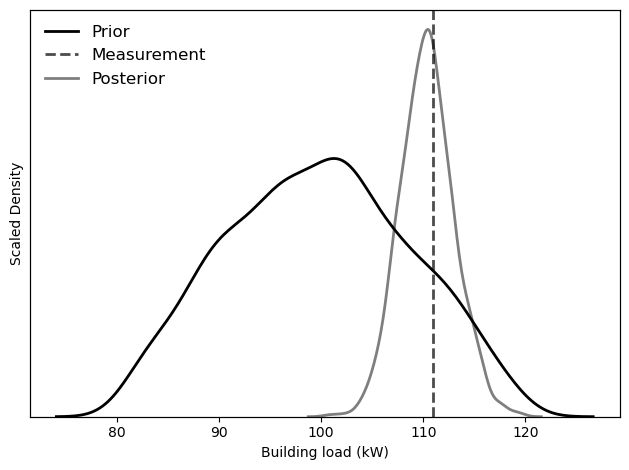

In [9]:
fig, ax = plt.subplots()

prior = sns.kdeplot(thetas,label='Prior',color='k',lw=2)

ymax = ax.get_ylim()[1]*1.5
msr = ax.vlines(z,0,ymax,label='Measurement',color='k', alpha=0.7, ls='--', lw=2)

ax2 = ax.twinx()
post = sns.kdeplot(
    samples,
    #cut=0,
    label='Posterior',
    ax=ax2, c='k', alpha=0.5, lw=2
)

ax.set_ylim(0,ymax)
ax.get_yaxis().set_ticks([])
ax.yaxis.set_label_text('Scaled Density')
ax.xaxis.set_label_text('Building load (kW)')
ax2.get_yaxis().set_ticks([])
ax2.yaxis.set_label_text('')

lns = ax.get_lines() + [msr] + ax2.get_lines()
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper left', frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join('plots','msr_uncertainty_reduction.pdf'), transparent=True)
plt.show()

#### Perform design with reduced uncertainty

In [10]:
tsamples = 50 # no. of samples from prior
vsamples = 10 # no. of samples from posterior
# we only use 10 samples in each SP as this provides a reasonable runtime for our example
# remember, the SP computational cost scales with roughlt the cube of the number of scenarios

posterior_results = []

In [11]:
for i in tqdm(range(tsamples), desc='Solving posterior problems'):
    ## Go get a cuppa, this one will take a while

    # sample from posterior distribution of load corresponding to measurement z
    # we've wrapped this in a function for convenience
    varthetas = sample_posterior(z=zs[i], nsamples=vsamples, msr_error=msr_error)

    # create scenarios by sampling from prior distributions of other uncertainties
    scenarios = {
        'solar_year': random.choice(solar_years, vsamples),
        'load_year': random.choice(load_years, vsamples),
        'mean_load': varthetas,
        'battery_efficiency': stats.truncnorm.rvs(-2, 2, loc=0.95, scale=0.05, size=vsamples),
        'battery_cost': stats.truncnorm.rvs(-2, 2, loc=70, scale=5, size=vsamples),
    }

    # optimise design over posterior distribution
    post_results = run_model(
        solar_capacity=None,
        battery_capacity=None,
        **scenarios
    )

    posterior_results.append(post_results)

Solving posterior problems:   0%|          | 0/50 [00:00<?, ?it/s]

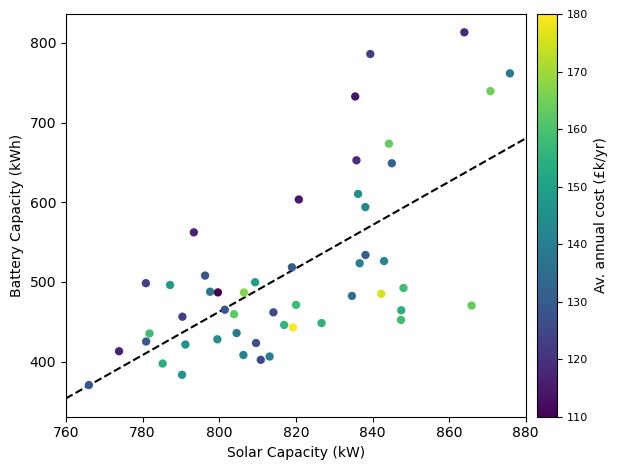

In [ ]:
solar_caps = [r['solar_capacity'] for r in posterior_results]
battery_caps = [r['battery_capacity'] for r in posterior_results]
costs = [s['total']/1e3 for s in posterior_results]

reg = linregress(solar_caps,battery_caps)

fig, ax = plt.subplots()

norm = plt.Normalize(round(0.975*min(costs),-1), round(1.025*max(costs),-1))
cmap = cmaps['viridis']

xmin = round(0.99*min(solar_caps),-1)
xmax = round(1.01*max(solar_caps),-1)
reg_xs = np.linspace(xmin, xmax, 100)
ax.plot(reg_xs, reg.slope*reg_xs + reg.intercept, 'k--', alpha=1, label='__nolegend__', zorder=0)

ax.scatter(
    x=solar_caps,
    y=battery_caps,
    c=costs,
    norm=norm,
    cmap=cmap,
    marker='o',
    alpha=1,
    cmap='viridis',
    lw=0,
)

cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap,norm=norm), ax=ax, pad=0.02)
cbar.set_label('Av. annual cost (£k/yr)')
cbar.ax.tick_params(labelsize=8)

plt.xlim(xmin, xmax)
plt.xlabel('Solar Capacity (kW)')
plt.ylabel('Battery Capacity (kWh)')

plt.tight_layout()
plt.savefig(os.path.join('plots','posterior_designs.pdf'), transparent=True)
plt.show()